In [1]:
import time, datetime
from options import parser
from models import FCNet,synthesisNet

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from imbalanced import ImbalancedDatasetSampler
from options import parser

# Dataloaders and Batch Sampling

In [2]:
class classificationData(Dataset):

    def __init__(self, inputDataPath,labelPath,transform=None):
        self.inputData = torch.tensor(np.load(inputDataPath),dtype=torch.float64)
        self.label = torch.tensor(np.load(labelPath),dtype=torch.float64)
        self.transform = transform

    def __len__(self):
        return self.inputData.shape[0]
                                 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        dataInfo = self.inputData[idx]
        labelInfo = self.label[idx]
        sample = (dataInfo,labelInfo.to(dtype=torch.long))

        if self.transform:
            sample = self.transform(sample)
        return sample

## Imbalanced Batch Sampler callback function for label query

In [3]:
def getLabelInfo(subset, idx):
    return subset.dataset.label[idx].item()

In [107]:
def get_dataloaders_train(args):
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
    trainValidData = classificationData('inputFeatures.npy','outputLabels.npy')
    train_set, valid_set = torch.utils.data.random_split(trainValidData, [2000, 530])
    train_loader = torch.utils.data.DataLoader(train_set,batch_size=args.batch_size_train,sampler=ImbalancedDatasetSampler(train_set,callback_get_label=getLabelInfo), **kwargs)
    test_loader = torch.utils.data.DataLoader(valid_set,batch_size=args.batch_size_valid,sampler=ImbalancedDatasetSampler(valid_set,callback_get_label=getLabelInfo), **kwargs)
    return train_loader, test_loader

In [5]:
def get_dataloaders_test(args):
    kwargs = {'num_workers': 4, 'pin_memory': True} if args.use_cuda else {}
    testData = classificationData('inputFeatures.npy','outputLabels.npy')
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=args.batch_size, shuffle=True, drop_last=False, **kwargs)
    return test_loader

In [106]:
args = parser.parse_args(args=[])
use_cuda = False
args.use_cuda = False
args.device = torch.device("cpu")
args.batch_size_train = 200
args.batch_size_valid = 10

# Model and Optimizer

In [148]:
def get_model(args):
    ''' define model '''
    model = synthesisNet(pathLength=27)
    print('---Model Information---')
    print('Net:', model)
    print('Use GPU:', args.use_cuda)
    return model.to(args.device)

In [149]:
def get_optimizer(args, model):
    ''' define optimizer '''
    #optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    print('\n---Optimization Information---')
    print('optimizer: Adam')
    print('batch size:', args.batch_size)
    print('lr:', args.lr)
    print('momentum:', args.momentum)
    return optimizer

In [150]:
# Ref: https://discuss.pytorch.org/t/solved-class-weight-for-bceloss/3114
def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:
        assert len(weights) == 2
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [151]:
train_loader, test_loader = get_dataloaders_train(args)

In [152]:
synModel = get_model(args).double()
optim_syn = get_optimizer(args,synModel)

---Model Information---
Net: synthesisNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=1, bias=True)
)
Use GPU: False

---Optimization Information---
optimizer: Adam
batch size: 10
lr: 0.01
momentum: 0.9


In [ ]:
torch.do

In [165]:
inputDim = torch.tensor((1, 27, 3)).double()

In [171]:
summary(synModel,(1,27,3),dtypes=[torch.DoubleTensor]*3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 25, 1]             320
            Linear-2                    [-1, 1]             801
      synthesisNet-3                    [-1, 1]               0
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------



(tensor(1121), tensor(1121))

In [153]:
from sklearn import metrics

In [154]:
lossValue = []
for i in range(50):
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(args.device), target.to(args.device)
        predict = synModel(data)
        #loss=F.binary_cross_entropy(torch.flatten(predict),target.double())
        loss=weighted_binary_cross_entropy(torch.flatten(predict), target.double(), weights=[0.1,0.8])
        train_loss += loss
        loss.backward()
        optim_syn.step()
    print(train_loss)
    lossValue.append(train_loss.item())
    

tensor(12.7802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18.4370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26.6623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10.3760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.5087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.6871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6.8426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.0963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3.8254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.6892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.7292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.2191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.2260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.7039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.9096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.6963, dtype=torch.float64, 

In [155]:
lossValue

[12.780153837068513,
 18.436952455132083,
 26.662256410205767,
 10.376035316885664,
 1.508746385934793,
 4.6870694744019605,
 6.842577083437261,
 6.195932789413623,
 5.096303924352751,
 3.825426843643176,
 2.6891844783863097,
 1.729232757034129,
 1.2190595611750419,
 1.2260449590173956,
 1.703870706008246,
 1.9096027533022206,
 2.6963380944213635,
 2.965029246133754,
 3.4683555421500767,
 3.420827409555244,
 3.4405468135576793,
 3.1388122601098623,
 3.16098808034539,
 2.86245076234665,
 2.5514804379211227,
 1.6700018176071068,
 1.362460877101143,
 1.267153734189583,
 1.337107968031709,
 1.7451833592075991,
 2.29269535442224,
 2.837784270241827,
 3.2977931127720748,
 3.7483378985534563,
 4.002135595000177,
 4.161548452879624,
 4.194306215185626,
 4.094567195920481,
 3.750650969295695,
 3.38772492969974,
 2.8645601130731917,
 2.3143616163431804,
 1.7338699668426831,
 1.3276874855377179,
 1.2802897353953597,
 1.476326003530405,
 1.9222412670758364,
 2.566214709768867,
 3.026756421021525,


No handles with labels found to put in legend.


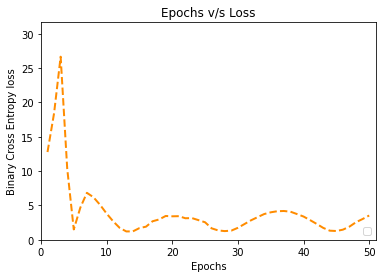

In [156]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
#plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([i for i in range(1,len(lossValue)+1)], lossValue, color='darkorange', lw=lw, linestyle='--')
plt.xlim([0,len(lossValue)+1])
plt.ylim([0.0,np.max(lossValue)+5])
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy loss')
plt.title('Epochs v/s Loss')
plt.legend(loc="lower right")
plt.show()

In [117]:
finalTgt = np.array([])
finalPrediction = np.array([])
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(args.device), target.to(args.device)
    predict = synModel(data)
    finalTgt = np.append(finalTgt,target.numpy())
    finalPrediction = np.append(finalPrediction,torch.flatten(predict).detach().numpy())

finalTgt.shape,finalPrediction.shape
#print(metrics.roc_auc_score(target.numpy(),torch.flatten(predict).detach().numpy()))

((2000,), (2000,))

In [118]:
finalPrediction,finalTgt

(array([0.05211797, 0.05211797, 0.05211797, ..., 0.05211797, 0.05211797,
        0.05211797]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [121]:
print(metrics.roc_curve(finalTgt,finalPrediction))
roc_auc= metrics.auc(metrics.roc_curve(finalTgt,finalPrediction)[0],metrics.roc_curve(finalTgt,finalPrediction)[1])

(array([0.        , 0.01607539, 0.0232816 , 0.11419069, 0.11862528,
       0.19733925, 0.19789357, 0.20121951, 0.69733925, 0.69733925,
       0.73392461, 0.73392461, 0.7921286 , 0.7921286 , 0.83980044,
       0.83980044, 0.84922395, 0.84922395, 0.85864745, 0.85864745,
       0.95288248, 0.95288248, 0.98170732, 1.        , 1.        ,
       1.        ]), array([0.        , 0.31122449, 0.3877551 , 0.47959184, 0.52040816,
       0.63265306, 0.65816327, 0.65816327, 0.65816327, 0.68877551,
       0.68877551, 0.72959184, 0.72959184, 0.7755102 , 0.7755102 ,
       0.81632653, 0.81632653, 0.82142857, 0.82142857, 0.89795918,
       0.89795918, 0.91836735, 0.91836735, 0.91836735, 0.94387755,
       1.        ]), array([1.05211797, 0.05211797, 0.05211797, 0.05211797, 0.05211797,
       0.05211797, 0.05211797, 0.05211797, 0.05211797, 0.05211797,
       0.05211797, 0.05211797, 0.05211797, 0.05211797, 0.05211797,
       0.05211797, 0.05211797, 0.05211797, 0.05211797, 0.05211797,
       0.05211797, 

In [127]:
fpr, tpr, thresholds = metrics.roc_curve(finalTgt,finalPrediction)
roc_auc = metrics.auc(fpr, tpr)

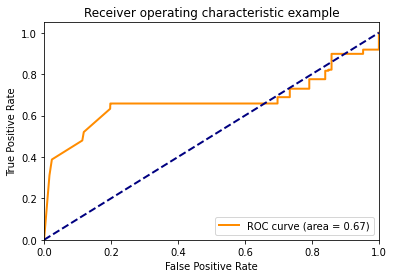

In [128]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(finalTgt,finalPrediction)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Train and Test

In [ ]:
def train(args, model, optimizer, train_loader, epoch):
    ''' define training function '''
    model.train()
    count = 0
    train_loss = 0
    train_correct = 0
    #MAX_BATCH = 150
    for batch_idx, (data, target) in enumerate(train_loader):
        # Ensuring that training happen with 7000 MNIST samples only
        # Balanced Sampling used to ensure count of each digits in
        # 7000 MNIST samples are same.
        #if (count > MAX_BATCH):
        #    break
        data, target = data.to(args.device), target.to(args.device)
        optimizer.zero_grad()
        c2Comb = target.size()[0]
        x1 = []
        x2 = []
        binTarget = []
        for i in range(c2Comb):
            for j in range(i):
                image1 = data[i]
                image2 = data[j]
                x1.append(image1.unsqueeze(0))
                x2.append(image2.unsqueeze(0))
                if (target[i] == target[j]):
                    binTarget.append(1)
                else:
                    binTarget.append(0)
        x1Tensor = torch.cat(x1, dim=0)
        x2Tensor = torch.cat(x2, dim=0)
        targetTensor = torch.tensor(binTarget)
        count += 1
        output = model(x1Tensor, x2Tensor)
        loss = F.nll_loss(output, targetTensor)
        train_loss += loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        train_correct += pred.eq(targetTensor.data.view_as(pred)).cpu().sum()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(binTarget), MAX_BATCH*len(binTarget),
                       100. * batch_idx / MAX_BATCH, loss.item()))

    print('\tTraining Accuracy (Avg.): {:.4f}\n'.format(train_correct.item() / (1225*MAX_BATCH)))
    #print("Train Loss before : "+str(train_loss))
    train_loss /= (MAX_BATCH) # Loss is computer as average loss over every batch
    #print("Train Loss after : " + str(train_loss))
    epoch_Training_Loss.append(train_loss)

In [ ]:
def test(args, model, test_loader):
    ''' define testing function '''
    model.eval()
    test_loss = 0
    correct = 0
    count=0
    batchCount = 0
    with torch.no_grad():
        for data, target in test_loader:
            if (batchCount > 150):
                break
            data, target = data.to(args.device), target.to(args.device)
            optimizer.zero_grad()
            c2Comb = target.size()[0]
            x1 = []
            x2 = []
            binTarget = []
            for i in range(c2Comb):
                for j in range(i):
                    image1 = data[i]
                    image2 = data[j]
                    x1.append(image1.unsqueeze(0))
                    x2.append(image2.unsqueeze(0))
                    if (target[i] == target[j]):
                        binTarget.append(1)
                    else:
                        binTarget.append(0)
            x1Tensor = torch.cat(x1, dim=0)
            x2Tensor = torch.cat(x2, dim=0)
            targetTensor = torch.tensor(binTarget)
            batchCount += 1
            count+=len(binTarget)
            output = model(x1Tensor, x2Tensor)
            test_loss += F.nll_loss(output, targetTensor, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(targetTensor.data.view_as(pred)).cpu().sum()

    #print(test_loss,count)
    test_loss /= count
    epoch_Test_Loss.append(test_loss)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, count,100. * correct / count))

In [50]:
args.batch_size

10

In [93]:
train_loader, test_loader = get_dataloaders_train(args)

In [94]:
len(train_loader),len(test_loader)

(200, 53)

In [78]:
train_loader.dataset.label[0]

tensor(1)

In [11]:
temp = np.load('inputFeatures.npy')

In [13]:
temp.shape

(2530, 1, 27, 3)

In [53]:
trainValidData = classificationData('inputFeatures.npy','outputLabels.npy')
train_set, valid_set = torch.utils.data.random_split(trainValidData, [2000, 530])

In [56]:
train_set

In [17]:
kwargs = {}

In [18]:
train_loader = torch.utils.data.DataLoader(trainValidData,batch_size=10, shuffle=True, drop_last=False, **kwargs)
test_loader = torch.utils.data.DataLoader(trainValidData,batch_size=10, shuffle=True, drop_last=False, **kwargs)